In [1]:
import numpy as np
from pythtb import *
from itertools import product

In [2]:
# used for testing purposes

def chessboard(t0, tprime, delta):
    # define lattice vectors
    lat=[[1.0, 0.0], [0.0, 1.0]]
    # define coordinates of orbitals
    orb=[[0.0, 0.0], [0.5, 0.5]]

    # make two dimensional tight-binding checkerboard model
    model = tb_model(2, 2, lat, orb)

    # set on-site energies
    model.set_onsite([-delta, delta], mode='reset')

    # set hoppings (one for each connected pair of orbitals)
    # (amplitude, i, j, [lattice vector to cell containing j])
    model.set_hop(-t0, 0, 0, [1, 0], mode='reset')
    model.set_hop(-t0, 0, 0, [0, 1], mode='reset')
    model.set_hop(t0, 1, 1, [1, 0], mode='reset')
    model.set_hop(t0, 1, 1, [0, 1], mode='reset')

    model.set_hop(tprime, 1, 0, [1, 1], mode='reset')
    model.set_hop(tprime*1j, 1, 0, [0, 1], mode='reset')
    model.set_hop(-tprime, 1, 0, [0, 0], mode='reset')
    model.set_hop(-tprime*1j, 1, 0, [1, 0], mode='reset')

    return model

def Haldane(delta, t, t2):
    lat=[[1, 0],[0.5, np.sqrt(3)/2]]
    orb=[[1/3, 1/3],[2/3, 2/3]]

    model = tb_model(2, 2, lat, orb)

    model.set_onsite([-delta, delta], mode='reset')

    for lvec in ([0, 0], [-1, 0], [0, -1]):
        model.set_hop(t, 0, 1, lvec, mode='reset')
        model.set_hop(t, 0, 1, lvec, mode='reset')

    for lvec in ([1, 0], [-1, 1], [0, -1]):
        model.set_hop(t2*1j, 0, 0, lvec, mode='reset')
        model.set_hop(t2*-1j, 1, 1, lvec, mode='reset')

    return model

# Constructing Bloch states
Ultimately we will do all this on a 2D k-mesh, not a path in k-space, so some details would need to change.
We are going to use wfs_psi, not wfs, in everything else we do for the Wannier constructions. 


Now, we need facilities for introducing the $e^{ik(R+\tau_j)}$ phase factors. The convention the PythTB code has is that `lat` is defined with numbers of unit length, while `orb` and `kvec` are defined in dimensionless units. For example, if we have a 2D unit cell with 2 orbitals
````
lat = [[a_11, a_12], [a_21, a_22]]
orb = [[n_11, n_12], [n_21, n_22]]
````
Such that 
$$
\vec{\tau}^{(i)} = n_{i, 1} \vec{a_1} + n_{i, 2} \vec{a_2} 
$$
Also, `kvec = [g_1, g_2]`, such that
$$
\vec{k}  = g_1 \vec{b_1} + g_2 \vec{b_2}
$$ 
Therefore, since $\vec{a_i} \cdot \vec{b_j} = 2\pi \delta_{ij}$
$$
\vec{k} \cdot \vec{\tau}^{(i)} = 2\pi (n_{i, 1} g_1 + n_{i, 2} g_2)
$$
So we need to take the inner product of the two lists multiplied by a factor of $2\pi$. Want list of phase factors at each k for each orbital, so it should be list of `shape(k_vec.shape[0], per_orb.shape[0])`

In [3]:
def gen_k_mesh(*nks, centered=False, flat=True, endpoint=False):
    if centered:
        end_pts = [-0.5, 0.5]
    else:
        end_pts = [0, 1]

    k_vals = [np.linspace(end_pts[0], end_pts[1], nk, endpoint=endpoint) for nk in nks]
    mesh = np.array(list(product(*k_vals)))

    if not flat:
        return mesh.reshape(*[nk for nk in nks], len(nks))

    return mesh

In [86]:
def get_orb_phases(model, k_vec, inverse=False):
  """
  Introduces e^i{k.tau} factors

  Args:
      model (pythb.tb_model): PythTB model
      k_vec (np.array): k space grid (assumes flattened)
      inverse (boolean): whether to get cell periodic (True) or Bloch (False) wfs

  Returns:
    orb_phases (np.array): array of phases at each k value
  """
  lam = (-1)**inverse  # overall minus if getting cell periodic from Bloch
  orb = model.get_orb()   # numpy array in order [orbital, reduced coord]
  per_dir = model._per    # list of periodic dimensions
  # slice second dimension to only keep only periodic dimensions in orb
  per_orb = orb[:, per_dir]
 
  # compute a list of phase factors [k_val, orbital]
  wf_phases = np.array(np.exp(lam * 1j* 2 * np.pi * per_orb @ k_vec.T), dtype=complex).T
  return wf_phases  # 1D numpy array of dimension norb

In [34]:
def get_bloch_wfs(model, u_wfs, k_mesh, inverse=False):
  """
  Change the cell periodic wfs to Bloch wfs
  
  Args:
    model (pythtb.tb_model): PythTB model
    wfs (pythtb.wf_array): cell periodic wfs [k, nband, norb]
    kvec (np.array): path in k space
      
  Returns:
    wfs_psi: np.array
      wfs with orbitals multiplied by proper phase factor

  """
  if isinstance(u_wfs, wf_array):
    nks = [*u_wfs._mesh_arr] # size of mesh in each direction
  else:
    nks = [*u_wfs.shape[0:2]]
  norb = model.get_num_orbitals() # number of orbitals

  psi_wfs = np.zeros((*nks, norb, norb), dtype=complex)  # [*nk_i, nband, norb]
  # Phases come in a list flattened over k space
  # Needs be reshaped to match k indexing of wf_array 
  phases = get_orb_phases(model, k_mesh, inverse=inverse).reshape(*nks, norb) 

  # important to note the subtle difference in wfs[k][:][i] and
  # wfs[k][:, i]
  if len(nks) == 1:
     for k in range(nks[0]):
      for i in range(norb):
        psi_wfs[k, :, i] = u_wfs[k][:, i] * phases[k, i]

  elif len(nks) == 2:
    for kx in range(nks[0]):
      for ky in range(nks[1]):
        for i in range(norb):
          psi_wfs[kx, ky, :, i] = u_wfs[kx, ky][:, i] * phases[kx, ky, i] 

  elif len(nks) == 3:
    for kx in range(nks[0]):
      for ky in range(nks[1]):
        for kz in range(nks[2]):
          for i in range(norb):
            psi_wfs[kx, ky, kz, :, i] = u_wfs[kx, ky, kz][:, i] * phases[kx, ky, kz, i] 

  return psi_wfs

# Computing Wannier functions

In general, it would be a good idea to have the ability to set
trial functions that are not necessarily just a delta on one site.
Here's a sketch of a more general mechanism, although it still
requires the trial function to be a linear combo of orbitals in
the home unit cell.  

Question: If we use a set of J trial functions, does $J \leq dim(H(k))$? If we only want the sum over occupied bands, then does $J \leq$ the dimensionality of the occupied manifold?

In [33]:
def set_trial_function(tf_list, norb):
  """
  Args:
      tf_list: list[int | tuple]
        list of numbers or tuples defining either the integer site 
        of the trial function (delta) or the tuples (site, amplitude)
      norb: int
        number of orbitals in the primative unit cell

  Returns:
      tfs (num_tf x norb np.array): 2 dimensional array of trial functions 
  """
 
  # number of trial functions to define
  num_tf = len(tf_list)

  # initialize array containing tfs = "trial functions"
  tfs = np.zeros([num_tf, norb], dtype=complex)

  for j, tf in enumerate(tf_list):
    if isinstance(tf, int): 
      # We only have a trial function on one site
      tfs[j, tf] = 1
    elif isinstance(tf, list):
      # Must be list of tuples of the form (site, amplitude)
      for site, amp in tf:
        tfs[j, site] = amp
      # normalizing 
      tfs[j,:] /= np.sqrt(sum(abs(tfs[j, :])))
    else:
      raise TypeError("tf_list is not of apporpriate type")

  # return numpy array containing trial functions
  return tfs # tfs in order[trial funcs, orbitals]

Defining $M = VW^{\dagger}$
$$|\tilde{\psi}_{nk}\rangle = \sum_{m=1}^N |\psi_{mk}\rangle M_{mn}^{(k)}$$
$$
\begin{pmatrix}
- \tilde{\psi}_{1k} - \\
- \tilde{\psi}_{2k} - \\
\vdots
\end{pmatrix}
=
\begin{pmatrix}
M_{11} & M_{12} & \cdots \\
M_{21} & M_{22} & \cdots \\
\vdots & \vdots
\end{pmatrix} ^{T}
\cdot
\begin{pmatrix}
- \psi_{1k} - \\
- \psi_{2k} - \\
\vdots
\end{pmatrix}
$$
$$
[- \tilde{\psi}_{1k} -] = \sum_{i} [ - M_{i1} \psi_{ik} -]
$$

In [48]:
def tf_overlap_mat(psi_wfs, tfs, n_occ):
    nks = psi_wfs.shape[:-2]
    ntfs = tfs.shape[0]

    A = np.zeros((*nks, n_occ, ntfs), dtype=complex)
    for n in range(n_occ):
        for j in range(ntfs):
            A[..., n, j] = (
                psi_wfs.conj()[..., n, :] @ tfs[j, :].T
            )
    return A

def get_psi_tilde(psi_wf, A):
    n_occ = A.shape[-2]
    nks = A.shape[:-2]
    V, S, Wh = np.linalg.svd(A, full_matrices=False)
    
    # swap only last two indices in transpose (ignore k indices)
    # slice psi_wf to keep only occupied bands
    psi_tilde = (
        (V @ Wh).transpose(*([i for i in range(len(nks))] +  [len(nks)+1, len(nks)])) @ psi_wf[..., :n_occ, :]
     ) # [*nk_i, nband, norb]
    return psi_tilde

def DFT(psi_tilde, norm=None):
    # axes can be [0], [0, 1], or [0, 1, 2] for dimensions 1, 2, 3 respectively
    Rn = np.fft.ifftn(psi_tilde, axes = [i for i in range(len(psi_tilde.shape[:-2]))], norm=norm)
    return Rn

def SVD_A(A):
    # SVD on last 2 axes by default (preserving k indices)
    return np.linalg.svd(A)

In [49]:
def Wannierize(model, u_wfs, k_mesh, tf_list, n_occ):
    n_orb = u_wfs._wfs.shape[-1]
    tfs = set_trial_function(tf_list, n_orb)

    psi_wfs = get_bloch_wfs(model, u_wfs, k_mesh)

    A = tf_overlap_mat(psi_wfs, tfs, n_occ)
    psi_tilde = get_psi_tilde(psi_wfs, A)

    Rn = DFT(psi_tilde)

    return Rn

# Procedure in principle

In [64]:
delta = 1
t0 = .1
tprime = .12

model = chessboard(t0, tprime, delta)#.make_supercell([[2,0], [0,2]])

In [65]:
# adding disorder
# J = 2
# J_site = 2
# model.set_onsite(J, ind_i = J_site, mode='add')

In [66]:
# model.display()

Define $k$ mesh

In [67]:
# 2D k-mesh
nkx = 50
nky = 50
k_mesh = gen_k_mesh(nkx, nky, flat=False, endpoint=False)
k_mesh_flat = gen_k_mesh(nkx, nky, flat=True, endpoint=False)

Reporting Chern number


In [68]:
n_occ = int(model.get_num_orbitals()/2)
u_wfs_chern = wf_array(model, [nkx, nky])
u_wfs_chern.solve_on_grid([0, 0])
chern = u_wfs_chern.berry_flux([i for i in range(n_occ)])/(2*np.pi)

print("Chern number: ", chern)

Chern number:  1.1043592643970545e-18


Don't want to use `solve_on_grid()`, since the we want a to exclude the endpoint.

Note: `solve_on_grid()` is equivalent to using `solve_on_point()` over the entire BZ (inclusive) and using `impose_pbc()` on all periodic directions

In [69]:
u_wfs_2d = wf_array(model, [nkx, nky])

for i in range(k_mesh.shape[0]):
    for j in range(k_mesh.shape[1]):
        u_wfs_2d.solve_on_one_point(k_mesh[i,j], [i,j])

Define trial functions and Wannierize

In [70]:
tf_list = [0] # delta on lower energy sites
w0 = Wannierize(model, u_wfs_2d, k_mesh_flat, tf_list, n_occ)

## Plotting

In [71]:
import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm

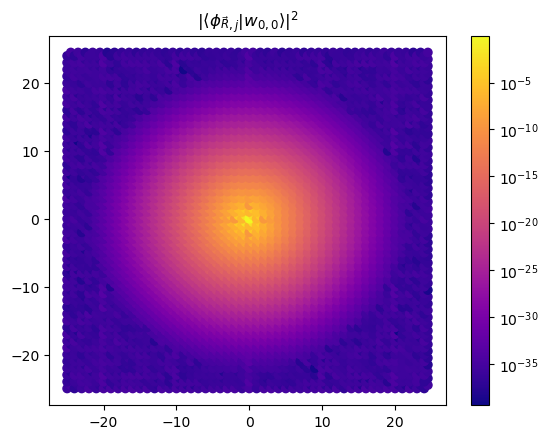

In [72]:
fig, ax = plt.subplots()

supercell = [(i,j) for i in range(-int((nkx-nkx%2)/2), int((nkx-nkx%2)/2)) 
             for j in range(-int((nky-nky%2)/2), int((nky-nky%2)/2))]

orbs = model.get_orb()
lat_vecs = model.get_lat()
idx = 0

xs = []
ys = []
zs = []

for tx, ty in supercell:
    for i, orb in enumerate(orbs):
        color = np.abs(w0[ty, tx, idx, i])**2
        pos = orb[0]*lat_vecs[0] + tx*lat_vecs[0] + orb[1]*lat_vecs[1]+ ty*lat_vecs[1]
        xs.append(pos[0])
        ys.append(pos[1])
        zs.append(color)

scat = ax.scatter(xs, ys, c=zs, cmap='plasma', norm=LogNorm())

fig.colorbar(scat)
ax.set_title(rf'$|\langle \phi_{{\vec{{R}}, j}}| w_{{0, {idx}}}\rangle|^2$')
plt.savefig('Wannier_weights_scatter.png')

### Plotting weights

In [73]:
idx = 0
cutoff = 20
r = []
w0i_wt = []

for tx, ty in supercell:
    for i, orb in enumerate(orbs):
        wt = np.abs(w0[tx, ty, idx, i])**2
        pos = orb[0]*lat_vecs[0] + tx*lat_vecs[0] + orb[1]*lat_vecs[1]+ ty*lat_vecs[1]

        r.append(np.sqrt(pos[0]**2 + pos[1]**2))
        w0i_wt.append(wt)

r = np.array(r)
w0i_wt = np.array(w0i_wt)
w0i_wt = w0i_wt[r < cutoff]
r = r[r < cutoff]

Binning the data

In [74]:
num_bins = int(np.ceil(max(r)))
r_bins = [[i, i + 1] for i in range(num_bins)]
r_ledge = [i for i in range(num_bins)]
r_cntr = [0.5 + i for i in range(num_bins)]
w0i_wt_bins = [[] for i in range(num_bins)]

# bins of weights
for i in range(r.shape[0]):
    for j, r_intvl in enumerate(r_bins):
        if r_intvl[0] <= r[i] < r_intvl[1]:
            w0i_wt_bins[j].append(w0i_wt[i])
            break

# average value of bins
avg_w0i_wt_bins = []
for i in range(num_bins):
    avg_w0i_wt_bins.append(sum(w0i_wt_bins[i])/len(w0i_wt_bins[i]))

# numpify
avg_w0i_wt_bins = np.array(avg_w0i_wt_bins)
r_ledge = np.array(r_ledge)
r_cntr = np.array(r_cntr)

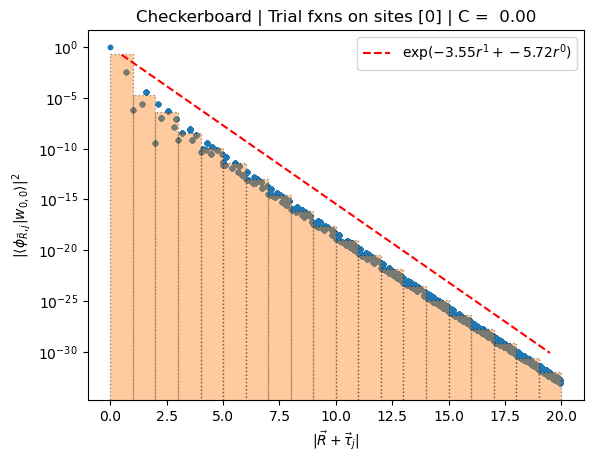

In [75]:
fig, ax = plt.subplots()

# scatter plot
plt.scatter(r, w0i_wt, zorder=1, s=10)

# bar of avgs
plt.bar(r_ledge, avg_w0i_wt_bins, width=1, align='edge', ec='k', zorder=2, ls=':', alpha=0.4)

# fit line
deg = 1
fit = np.polyfit(r_cntr, np.log(avg_w0i_wt_bins), deg)
fit_line = np.sum(np.array([r_cntr**(deg-i) * fit[i] for i in range(deg)]), axis=0)
fit_eqn = '+'.join([fr'{c: .2f} r^{deg-j}' for j, c in enumerate(fit)])
plt.plot(r_cntr, np.exp(fit_line), c='r', ls='--', label=fr"$\exp({fit_eqn})$")

ax.legend()
ax.set_ylabel(rf'$|\langle \phi_{{\vec{{R}}, j}}| w_{{0, {idx}}}\rangle|^2$')
ax.set_xlabel(r'$|\vec{R}+\vec{\tau}_j|$')
# ax.set_xticks(r_cntr)
ax.set_yscale('log')
ax.set_title(f'Checkerboard | Trial fxns on sites {tf_list} | C = {chern: .2f}')
plt.savefig(f'weights_bar_plot_C={chern: .2f}.png')

## Quadratic Spread

#### Real space

In [76]:
def spread_real(w0, orbs, lat_vecs, decomp=False):
    """
    Spread functional computed in real space with Wannier functions

    Args:
        w0 (np.array): Wannier functions
        supercell (np.array): lattice translation vectors in reduced units
        orbs (np.array): orbital vectors in reduced units
        decomp (boolean): whether to separate gauge (in)variant parts of spread

    Returns:
        Omega: the spread functional
        Omega_inv: (optional) the gauge invariant part of the spread
        Omega_tilde: (optional) the gauge dependent part of the spread
        expc_rsq: \sum_{n} <r^2>_{n}
        expc_r_sq: \sum_n <\vec{r}>_{n}^2
    """
    nx, ny, n_occ = w0.shape[0], w0.shape[1], w0.shape[2]
    supercell = [(i,j) for i in range(-int((nx-nx%2)/2), int((nx-nx%2)/2)) 
                for j in range(-int((ny-ny%2)/2), int((ny-ny%2)/2))]
    r_n = np.zeros((n_occ, 2), dtype=complex) # <\vec{r}>_n
    rsq_n = np.zeros(n_occ, dtype=complex) # <r^2>_n
    R_nm = np.zeros((2, n_occ, n_occ, nx*ny), dtype=complex)

    expc_rsq = 0 # <r^2> 
    expc_r_sq = 0 # <\vec{r}>^2

    for n in range(n_occ): # "band" index
        for tx, ty in supercell: # cells in supercell
            for i, orb in enumerate(orbs): # values of Wannier function on lattice
                w0n_r = w0[tx, ty, n, i] # Wannier function
                pos = (orb[0] + tx)*lat_vecs[0] + (orb[1] + ty)*lat_vecs[1] # position
                r = np.sqrt(pos[0]**2 + pos[1]**2)

                # expectation value of position (vector)
                r_n[n, :] += np.array([pos[0] * abs(w0n_r)**2, pos[1] * abs(w0n_r)**2])
                rsq_n[n] += r**2 * w0n_r*w0n_r.conj()

                if decomp:
                    for m in range(n_occ):
                        for j, [dx, dy] in enumerate(supercell):
                            wRm_r = w0[(tx+dx)%nx, (ty+dy)%ny, n, i] # Wannier function
                            R_nm[0, n, m, j] += pos[0] * w0n_r*wRm_r.conj()
                            R_nm[1, n, m, j] += pos[0] * w0n_r*wRm_r.conj()

        expc_rsq += rsq_n[n]
        expc_r_sq += np.vdot(r_n[n, :], r_n[n, :])

    spread = expc_rsq - expc_r_sq

    if decomp:
        Omega_inv = 0 # gauge invariant part of spread
        Omega_tilde = 0 # gauge dependent part of spread

        Omega_inv += expc_rsq
        for i in range(R_nm.shape[1]):
            for j in range(R_nm.shape[2]):
                for k in range(R_nm.shape[3]):
                    Omega_inv -= np.vdot(R_nm[:, i, j, k], R_nm[:, i, j, k])
                    if not (i == j and supercell[k] == (0,0)):
                        Omega_tilde += np.vdot(R_nm[:, i, j, k], R_nm[:, i, j, k])

        assert np.allclose(spread, Omega_inv+Omega_tilde)
        return [spread, Omega_inv, Omega_tilde], expc_rsq, expc_r_sq

    else:
        return spread, expc_rsq, expc_r_sq

def get_projector(states, bands, Wannier=False):
    nx, ny = states.shape[0], states.shape[1]
    P_s = np.array([[ 
        np.sum( [np.outer(states[x, y, n, :].T, states[x, y, n, :].conj()) for n in bands], axis=0)
               for y in range(ny)] for x in range(nx)]) 
    
    P = (nx*ny if Wannier else 1) * np.sum(P_s, axis=(0,1))
    Q = np.eye(P.shape[0]) - P
    
    return P, Q

In [77]:
spread, expc_rsq, expc_r_sq = spread_real(w0, orbs, lat_vecs, decomp=True)

In [78]:
print(f"Real space spread: {spread[0]: .11f}")
print(f"Real space <r^2> = {expc_rsq: .11f}")
print(f"Real space <r>^2 = {expc_r_sq: .11f}")
print(rf"Omega_I = {spread[1]: .11f}")
print(rf"\tilde{{Omega}} = {spread[2]: .11f}")
print(rf"Omega_I + \tilde{{Omega}} = {spread[1] + spread[2]: .11f}" )

Real space spread:  0.00796334100-0.00000000000j
Real space <r^2> =  0.00796334100-0.00000000000j
Real space <r>^2 =  0.00000000000+0.00000000000j
Omega_I =  0.00789790934-0.00000000000j
\tilde{Omega} =  0.00006543166+0.00000000000j
Omega_I + \tilde{Omega} =  0.00796334100-0.00000000000j


#### Reciprocal space

In [80]:
def k_overlap_mat(u_wfs, num_NN, n_occ, orbs=None):
    """ 
    Compute the overlap matrix of Bloch eigenstates. Assumes that the last u_wf
    along each periodic direction corresponds to the next to last k-point in the 
    mesh (excludes endpoints). This way, the periodic boundary conditions are handled 
    internally.

    Args:
        u_wfs (np.array | wf_array): The cell periodic Bloch wavefunctions
        num_NN (int): number of nearest neighbors at a reciprocal lattice site
        n_occ (int): number of occupied eigenstates

    Returns:
        M (np.array): overlap matrix
    """
    if isinstance(u_wfs, wf_array):
        nks = [*u_wfs._mesh_arr] # size of mesh in each direction
        nkx, nky = nks[0], nks[1]
        orbs = u_wfs._model.get_orb()
    else:
        nks = [*u_wfs.shape[0:2]]
        nkx, nky = nks[0], nks[1]
        assert orbs is not None, "Need to specify orbital vectors"
    
    # assumes that there is no last element in the k mesh, so we need to introduce phases
    M = np.zeros((nkx, nky, num_NN, n_occ, n_occ), dtype=complex) # overlap matrix
    for n in range(n_occ): # band index right (occupied)
        for m in range(n_occ): # band index left (occupied)
            for kx in range(nkx):
                for ky in range(nky): 
                    for nn in range(num_NN): # nearest neighbors
                        # pbc at edge of BZ
                        if nn == 0:
                            M[kx, ky, nn, m, n] = np.vdot(
                                u_wfs[kx, ky][m, :], u_wfs[(kx+1)%nkx, ky][n, :] *
                                (np.array(np.exp(-1j*2*np.pi*orbs @ np.array([1,0]).T ), dtype=complex).T if kx == nkx-1
                                 else 1) 
                                )
                        elif nn == 1:
                            M[kx, ky, nn, m, n] = np.vdot(
                                u_wfs[kx, ky][m, :], u_wfs[kx, (ky+1)%nky][n, :] *
                                (np.array(np.exp(-1j*2*np.pi*orbs @ np.array([0,1]).T ), dtype=complex).T if ky == nky-1
                                 else 1) 
                                )
                        elif nn == 2:
                            M[kx, ky, nn, m, n] = np.vdot(
                                u_wfs[kx, ky][m, :], u_wfs[kx-1, ky][n, :] *
                                (np.array(np.exp(-1j*2*np.pi*orbs @ np.array([-1,0]).T ), dtype=complex).T if kx == 0
                                 else 1) 
                                )
                        elif nn == 3:
                            M[kx, ky, nn, m, n] = np.vdot(
                                u_wfs[kx, ky][m, :], u_wfs[kx, ky-1][n, :] *
                                (np.array(np.exp(-1j*2*np.pi*orbs @ np.array([0,-1]).T ), dtype=complex).T if ky == 0
                                 else 1) 
                                 )
    return M

def spread_recip(M, w_b, b_vec, decomp=False):
    """
    Args:
        M (np.array): 
            overlap matrix
        w_b (int): 
            finite difference weights
        b_vec (list[np.array]): 
            vectors connected NN reciprocal lattice sites
        decomp (bool, optional): 
            Whether to compute and return decomposed spread. Defaults to False.

    Returns:
        spread | [spread, Omega_i, Omega_tilde], expc_rsq, expc_r_sq : 
            quadratic spread, the expectation of the position squared,
            and the expectation of the position vector squared
    """
    nkx, nky = M.shape[0], M.shape[1] # mesh size
    N_k = nkx*nky # number of k points in first BZ
    r_n = np.zeros((n_occ, 2), dtype=complex) # <\vec{r}>_n
    rsq_n = np.zeros(n_occ, dtype=complex) # <r^2>_n
    expc_rsq = 0 # <r^2> 
    expc_r_sq = 0 # <\vec{r}>^2

    for n in range(n_occ):
        for kx in range(nkx):
            for ky in range(nky):
                for idx, b in enumerate(b_vec):
                    r_n[n, :] += -(1/N_k) * w_b * b * np.log(M[kx, ky, idx, n, n]).imag
                    rsq_n[n] += (1/N_k) * w_b * (1 - abs(M[kx, ky, idx, n, n])**2 + np.log(M[kx, ky, idx, n, n]).imag**2)
                    
        expc_rsq += rsq_n[n] # <r^2> 
        expc_r_sq += np.vdot(r_n[n, :], r_n[n, :]) # <\vec{r}>^2
        
    spread = expc_rsq - expc_r_sq
                                
    if decomp:
        Omega_i = 0
        Omega_tilde = 0
        for kx in range(nkx):
            for ky in range(nky):
                for idx, b in enumerate(b_vec):
                    Omega_i += (1/N_k) * w_b * n_occ 
                    for n in range(n_occ):
                        Omega_tilde += (1/N_k) * w_b * (-np.log(M[kx, ky, idx, n, n]).imag - np.vdot(b, r_n[n]))**2
                        for m in range(n_occ):
                            Omega_i -= (1/N_k) * w_b * abs(M[kx, ky, idx, m, n])**2
                            if m != n:
                                Omega_tilde += (1/N_k) * w_b * abs(M[kx, ky, idx, m, n])**2
                                
        return [spread, Omega_i, Omega_tilde], expc_rsq, expc_r_sq
    
    else: 
        return spread, expc_rsq, expc_r_sq
    
def get_pbc_phase(orbs, G):
    """
    Get phase factors for cell periodic pbc across BZ boundary

    Args:
        orbs (np.array): reduced coordinates of orbital positions
        G (list): reduced coordinates of reciprocal lattice vector

    Returns:
        phase: phase factor to be multiplied to last cell periodic eigenstates
        in k-mesh 
    """
    phase = np.array(np.exp(-1j*2*np.pi*orbs @ np.array(G).T ), dtype=complex).T
    return phase

In [81]:
# 2D k-mesh
nkx = 100
nky = 100
N = nkx*nky
num_NN = 4 # number of nearest neighbors in reciprocal lattice
b = 2*np.pi/nkx # spacing between allowed kx
b_vec = [np.array([b, 0]), np.array([0, b]), np.array([-b, 0]), np.array([0, -b])] # vectors connecting nearest neighbor k points
w_b = 1/(2*b**2) # finite difference weights for cubic lattice

In [82]:
k_mesh_flat = gen_k_mesh(nkx, nky, flat=True, endpoint=False)
k_mesh = gen_k_mesh(nkx, nky, flat=False, endpoint=False)

# eigenvectors on k-mesh (excluding end point)
u_wfs = wf_array(model, [nkx, nky])

for i in range(k_mesh.shape[0]):
    for j in range(k_mesh.shape[1]):
        u_wfs.solve_on_one_point(k_mesh[i,j], [i,j])

In [83]:
# getting cell periodic psi_tildes
psi_wfs = get_bloch_wfs(model, u_wfs, k_mesh_flat)

n_orb = u_wfs._wfs.shape[-1]
tfs = set_trial_function(tf_list, n_orb)
A = tf_overlap_mat(psi_wfs, tfs, n_occ)
psi_tilde = get_psi_tilde(psi_wfs, A)
u_tilde = get_bloch_wfs(model, psi_tilde, k_mesh_flat, inverse=True)

In [84]:
M = k_overlap_mat(u_tilde, num_NN, n_occ, orbs=model.get_orb())
spread, expc_rsq, expc_r_sq = spread_recip(M, w_b, b_vec, decomp=True)

In [85]:
print(f"Reciprocal space spread: {spread[0]: .8f}")
print(f"Reciprocal space <r^2> = {expc_rsq: .8f}")
print(f"Reciprocal space <r>^2 = {expc_r_sq: .8f}")
print(rf"Reciprocal space Omega_I = {spread[1]: .8f}")
print(rf"Reciprocal space \tilde{{Omega}} = {spread[2]: .8f}")
print(rf"Omega_I + \tilde{{Omega}} = {spread[1] + spread[2]: .8f}" )

Reciprocal space spread:  0.00796209+0.00000000j
Reciprocal space <r^2> =  0.00796209+0.00000000j
Reciprocal space <r>^2 =  0.00000000+0.00000000j
Reciprocal space Omega_I =  0.00789669
Reciprocal space \tilde{Omega} =  0.00006540+0.00000000j
Omega_I + \tilde{Omega} =  0.00796209+0.00000000j


# Testing 

Eventually would like to compare results to initial findings (1d path)

In [87]:
# 1D k path
nk = 5
path = [[0.0, 0.0], [0.0, 0.5], [0.5, 0.5], [0.0, 0.0]]
(k_vec, k_dist, k_node) = model.k_path(path, nk, report=False)

u_wfs_1d = wf_array(model, [nk])

for k in range(nk):
    u_wfs_1d.solve_on_one_point([k_vec[k,0], k_vec[k,1]], [k])

### Periodic Boundary Conditions

Using the periodic gauge,
$$
\psi_{n, \vec{k} + \vec{G}}(\vec{r}) = \psi_{n, \vec{k}}(\vec{r})
$$
Leading to
$$
u_{n, \vec{k}+\vec{G}}(\vec{r}) = e^{-i\vec{G}\cdot \vec{r}} u_{n\vec{k}}(\vec{r})
$$
In the tight binding language, this means
$$
C_{n, \vec{k}+\vec{G}}^{(j)} = e^{-i \vec{G}\cdot\vec{\tau_j} }C_{n, \vec{k}}^{(j)} 
$$
For our checkerboard lattice, 
$$
\vec{\tau}_1 = 0
$$
$$
\vec{\tau}_2 = \frac{1}{2}(\vec{a}_1 + \vec{a_2})
$$
Leading to
$$
\vec{G}\cdot\vec{\tau_1} = 0
$$
$$
\vec{G}\cdot\vec{\tau_2} = (m_1 \vec{b}_1 + m_2 \vec{b}_2) \cdot \frac{1}{2}(\vec{a_1}+\vec{a_2}) \\
= \pi (m_1 + m_2)
$$


In [186]:
# 2D k-mesh
nkx = 10
nky = 10
N = nkx*nky

k_mesh = gen_k_mesh(nkx, nky, flat=False, endpoint=False)
k_mesh_flat = gen_k_mesh(nkx, nky, flat=True, endpoint=False)

In [187]:
u_wfs = wf_array(model, [nkx, nky])

for i in range(k_mesh.shape[0]):
    for j in range(k_mesh.shape[1]):
        u_wfs.solve_on_one_point(k_mesh[i,j], [i, j])

# solving for eigenstates over full BZ
u_wfs_full = wf_array(model, [nkx, nky])
u_wfs_full.solve_on_grid([0, 0])

array([1.25899544])

In [188]:
np.vdot(u_wfs[0, 7][0, :], u_wfs[0, 8][0, :])

(0.9992017761611243-1.7447136697059596e-19j)

In [189]:
np.vdot(u_wfs[0, 8][0, :], u_wfs[0, 9][0, :])

(0.9992012433852383+5.948449097682157e-19j)

In [190]:
np.vdot(u_wfs[0, 9][0, :], u_wfs[0, 0][0, :])

(-0.9992615316399783+0j)

In [191]:
u_wfs.impose_pbc(mesh_dir=0, k_dir=0)
u_wfs.impose_pbc(mesh_dir=1, k_dir=1)

In [192]:
np.exp(-2.j*np.pi*model._orb[:,1])

array([ 1.+0.0000000e+00j, -1.-1.2246468e-16j])

In [193]:
k_mesh_end = gen_k_mesh(nkx, nky, centered=False, endpoint=True)
phases = get_orb_phases(model, k_mesh_end)
phases.shape

(100, 2)

Cell periodic wavefunctions orthogonality

$$
\langle u_{nk} | u_{mk} \rangle = \delta_{nm}
$$

In [194]:
# ensure orthogonality at same k
for i in range(u_wfs._wfs.shape[0]):
    for j in range(u_wfs._wfs.shape[1]):
        print(
        np.allclose(u_wfs[i, j].conj() @ u_wfs[i, j].T, np.eye(u_wfs._wfs.shape[-2], u_wfs._wfs.shape[-2]))
        )

True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True


Bloch wavefunctions
$$
|\psi_{nk}\rangle = e^{i\vec{k}\cdot \vec{r}} | u_{nk} \rangle
$$

In [195]:
psi_wfs = get_bloch_wfs(model, u_wfs, k_mesh_flat)

In [196]:
abs(np.vdot(psi_wfs[0, 5, 0, :], psi_wfs[0, 6, 0, :]))

0.9987486411640465

In [197]:
abs(np.vdot(psi_wfs[0, 6, 0, :], psi_wfs[0, 7, 0, :]))

0.998623643432062

In [198]:
abs(np.vdot(psi_wfs[0, 7, 0, :], psi_wfs[0, 8, 0, :]))

0.9987531822877989

In [199]:
abs(np.vdot(psi_wfs[0, 8, 0, :], psi_wfs[0, 9, 0, :]))

0.9969279128918582

In [200]:
np.vdot(psi_wfs[0, 9, 0, :], psi_wfs[0, 0, 0, :])

(1+0j)

In [201]:
np.vdot(psi_wfs[0, 0, 0, :], psi_wfs[0, 1, 0, :])

(-0.9992615316399783+0j)

Orthonormality,
$$
\langle \psi_{nk} | \psi_{mk} \rangle = \delta_{nm}
$$

In [202]:
# ensure orthogonality at same k
for i in range(psi_wfs.shape[0]):
    for j in range(psi_wfs.shape[1]):
        print(
        np.allclose(psi_wfs[i, j].conj() @ psi_wfs[i, j].T, np.eye(psi_wfs.shape[-2], psi_wfs.shape[-2]))
        )

True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True


Occupied band projector

$$P_k = \sum_{n=1}^{n_{occ}} |\psi_{nk} \rangle \langle \psi_{nk}|$$

In [203]:
P_k, Q_k = get_projector(psi_wfs, bands = range(n_occ))

Inner product matrix
$$(A_k)_{mn} = \langle \psi_{mk} | g_n \rangle$$

In [204]:
norb = len(model.get_orb())
tfs = set_trial_function(tf_list, norb)
tfs

array([[1.+0.j, 0.+0.j]])

In [205]:
A = tf_overlap_mat(psi_wfs, tfs, n_occ)
A.shape

(10, 10, 1, 1)

$$ A = V S W^{\dagger}$$
$$ M = V W^{\dagger} $$

In [206]:
V, S, Wh = np.linalg.svd(A, full_matrices=False)
M = V @ Wh
M.shape

(10, 10, 1, 1)

$$M M^{\dagger} = 1$$

In [207]:
# Unitarity check
for i in range(M.shape[0]):
    for j in range(M.shape[1]):
        print(
        np.allclose(M[i, j].conj().T @ M[i, j], np.eye(M.shape[-1], M.shape[-1])) 
        )

True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True


Smoothened Bloch states 
$$|\tilde{\psi}_{nk} \rangle = \sum_{m=1}^{n_{occ}} |\psi_{mk} \rangle M_{mn}$$


In [208]:
psi_tilde = get_psi_tilde(psi_wfs, A)
psi_tilde.shape

(10, 10, 1, 2)

In [209]:
np.vdot(psi_tilde[0, 5, 0, :], psi_tilde[0, 6, 0, :])

(0.9987200472374714+0.007557477953137584j)

In [210]:
np.vdot(psi_tilde[0, 6, 0, :], psi_tilde[0, 7, 0, :])

(0.998608611591787+0.005479240481088808j)

In [211]:
np.vdot(psi_tilde[0, 7, 0, :], psi_tilde[0, 8, 0, :])

(0.9987490927248582+0.0028581307313940607j)

Projector 
$$\tilde{P}_k = \sum_{n=1}^{n_{occ}} |\tilde{\psi}_{nk} \rangle \langle \tilde{\psi}_{nk}|$$

In [215]:
P_til_k, Q_til_k = get_projector(psi_tilde, bands=range(n_occ))

$$ \langle \tilde{\psi}_{n, k'} | \tilde{\psi}_{m,k'} \rangle = \delta_{n,m}$$ 

In [218]:
for i in range(psi_tilde.shape[0]):
    for j in range(psi_tilde.shape[1]):
        print(
        np.allclose(psi_tilde[i, j].conj() @ psi_tilde[i, j].T, np.eye(psi_tilde.shape[-2], psi_tilde.shape[-2]))
        )

True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True


Wannier construction

$$
|Rn \rangle = \frac{1}{N} \sum_{k} e^{-i\vec{k}\cdot\vec{R}} |\psi_{nk}\rangle 
$$

In [219]:
# forward norm puts factor of 1/N in front
Rn = np.fft.fftn(psi_tilde, axes = (0, 1), norm='forward')
Rn.shape

(10, 10, 1, 2)

Projector
$$
P_R = \sum_{n} |n\vec{R} \rangle \langle n\vec{R} |
$$

In [223]:
P_R, Q_R = get_projector(Rn, bands=range(n_occ), Wannier=True)

Equivalence of Bloch wavefunction projector and Wannier projector

$$ N\sum_{R} P_R = \sum_{k} \tilde{P}_k = \sum_k P_k$$

In [224]:
print(np.allclose(P_R, P_til_k))
print(np.allclose(P_R, P_k))
print(np.allclose(P_k, P_til_k))

True
True
True


$$ \langle R, n | R, n \rangle \neq 1 $$ 
$$\sum_R \langle R, n | R, n \rangle = 1 $$ 


In [84]:
np.sum(np.array([[np.vdot(Rn[i, j, 0, :], Rn[i, j, 0, :]) for i in range(Rn.shape[0])] for j in range(Rn.shape[1])]), axis=(0,1))

(0.9999999999999998-5.958697044808768e-21j)